- [1. Importing Datsets and Functions](#1)
- [2. Assembling Datasets](#2)
- [3. PCA and KNN](#3)
    - [3.1 PCA](#3_1)
    - [3.2 KNN](#3_2)
- [4. Hyperparameters Tuning](#4)

## 1. Import Datasets and Functions

In [12]:
from tqdm import tqdm  # Import tqdm
import pandas as pd
import numpy as np
import sklearn
import torch.nn as nn
import sklearn.model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier


from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [3]:
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

def rest_days(team):
    team['date_time'] = pd.to_datetime(team['date'])
    team['rest'] = (team['date_time'] - team['date_time'].shift(1)).dt.days
    team['rest'] = team['rest'].fillna(0)
    team['rest'] = team['rest'].astype(int)
    del team['date_time']
    return team

def winrate(team):
    total = team['Wins'] + team['Losses']
    total_opp = team['Wins_opp'] + team['Losses_opp']
    team['winrate'] = team['Wins'] / total
    team['winrate_opp'] = team['Wins_opp'] / total_opp
    return team

def differential(team):
    team['differential'] = team['Total'] - team['Total_opp']
    return team

def find_team_exp_average_5(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=5, adjust=False).mean()
    return rolling

def find_team_exp_average_9(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=9, adjust=False).mean()
    return rolling

def find_team_exp_average_12(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=12, adjust=False).mean()
    return rolling

def find_team_average_15(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(15).mean()
    return rolling

def find_team_average_10(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(10).mean()
    return rolling

def find_team_average_5(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(5).mean()
    return rolling

def find_team_average_3(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(3).mean()
    return rolling

def rolling(data):
    df_rolling_3 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_3 = df_rolling_3.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_3)
    df_rolling_5 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_5 = df_rolling_5.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_5)
    df_rolling_10 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_10 = df_rolling_10.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_10)
    df_rolling_15 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_15 = df_rolling_15.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_15)
    df_exp_rolling_5 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_5 = df_exp_rolling_5.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_5)
    df_exp_rolling_9 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_9 = df_exp_rolling_9.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_9)
    df_exp_rolling_12 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_12 = df_exp_rolling_12.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_12)
    exp_rolling_columns_5 = [f"{col}_exp_5" for col in df_exp_rolling_5.columns]
    exp_rolling_columns_9 = [f"{col}_exp_9" for col in df_exp_rolling_9.columns]
    exp_rolling_columns_12 = [f"{col}_exp_12" for col in df_exp_rolling_12.columns]
    rolling_columns_15 = [f"{col}_15" for col in df_rolling_15.columns]
    rolling_columns_10 = [f"{col}_10" for col in df_rolling_10.columns]
    rolling_columns_5 = [f"{col}_5" for col in df_rolling_5.columns]
    rolling_columns_3 = [f"{col}_3" for col in df_rolling_3.columns]
    df_exp_rolling_12.columns = exp_rolling_columns_12
    df_exp_rolling_9.columns = exp_rolling_columns_9
    df_exp_rolling_5.columns = exp_rolling_columns_5
    df_rolling_15.columns = rolling_columns_15
    df_rolling_10.columns = rolling_columns_10
    df_rolling_5.columns = rolling_columns_5
    df_rolling_3.columns = rolling_columns_3
    df = pd.concat([data, df_rolling_3, df_rolling_5, df_rolling_10, df_rolling_15, df_exp_rolling_5,df_exp_rolling_9, df_exp_rolling_12], axis=1)
    # df_exp_rolling_5,df_exp_rolling_9, df_exp_rolling_12
    return df

def ratio(feature):
    feature_opp = 'OPP_' + str(feature)
    free = nba[feature] / nba[feature_opp]
    return free

def ratios(nba):
    regard = []
    disregard = [col for col in nba.columns if "OPP_" in col]
    for col in disregard:
        col = col[4:100]
        if col in nba.columns:
            regard.append(col)
    nba_ratio = nba[regard].apply(ratio)
    nba_ratios_columns = [f"{col}_ratio" for col in nba_ratio.columns]
    nba_ratio.columns
    return regard

def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("Teams", group_keys=False).apply(lambda x: shift_col(x, col_name))

def date_change(datetime_str):
    # Parse the datetime string into a datetime object
    datetime_obj = datetime.strptime(datetime_str, '%m/%d/%Y')

    # Format the datetime object into a new string structure
    new_datetime_str = datetime_obj.strftime('%Y-%m-%d')

    return new_datetime_str

def haircut(df, date):
    df[date] = df[date].str[:10]
    return df

def convert_date_format(df):
    # Create a boolean mask to identify values in the "m/d/y" format
    mask = df['Date'].str.contains(r'\d{1,2}/\d{1,2}/\d{2}')
    
    # Apply the conversion only to values that match the mask
    df.loc[mask, 'Date'] = nba.loc[mask, 'Date'].apply(date_change)
    return df

def spread(df):
    # construct spread between home and away rankings
    ranks = [i for i in df.columns if 'RANK' in i]
    ranks_home = [i for i in ranks if '_x' in i]
    ranks_away = [i for i in ranks if '_y' in i]
    spread_columns_names = [col[:-1] for col in ranks_home]
    
    spread_columns = []
    for base_name in spread_columns_names:
        spread_column = df[f'{base_name}x'] - df[f'{base_name}y']
        spread_column.name = f'{base_name}spread'
        spread_columns.append(spread_column)
        
    spread_df = pd.concat(spread_columns, axis=1)
    return spread_df

def last_season(df):
    # construct winrate from last season
    df['last_season_winrate'] = df.groupby('Teams', 'season')['winrate'].last()

## 2. Assembling Dataset <a id='2'></a>

In [4]:
folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/raw_data/NBA_2018_2024.csv"
folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/raw_data/NBA_2018_2024.csv"

df = pd.read_csv(folder_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/nba_api/data/teams_stats/processed_cumulative_season_stats_2019_2024.csv"
folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/nba_api/data/teams_stats/processed_cumulative_season_stats_2019_2024.csv"
nba = pd.read_csv(folder_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [5]:
# nba dataframe does not include the 2018 season
df = df[~df['season'].isin([2018])]
df = df.reset_index(drop=True)
df = haircut(df, 'date')

# rename nba columns to match df
nba = haircut(nba, 'Date')
nba = convert_date_format(nba)
nba.rename(columns={'Date': 'date'}, inplace=True)

#rename odds columns to match df
odds.rename(columns={'Timestamp': 'date_next'}, inplace=True)

# construct winrate for team
df = winrate(df)
# construct differential points
df = differential(df)
# construct target
df = df.groupby("Teams", group_keys=False).apply(add_target)
# construct resting
df = df.groupby(["Teams",'season'], group_keys=False).apply(rest_days)
# games yet to play are 2
df.loc[pd.isnull(df['target']), 'target'] = 2
# convert win/loss to 1/0
df['target'] = df['target'].astype(int)

# remove metadata and target for df
removed = ['target', 'date', 'Teams_opp', 'Teams',
           'season','won', 'Wins', 'Losses', 
           'Wins_opp', 'Losses_opp']
valid_columns = df.columns[~df.columns.isin(removed)]

# scale the data for df
scaler = MinMaxScaler()
df[valid_columns] = scaler.fit_transform(df[valid_columns])

# construct rolling features to df
df = rolling(df).copy()
df = df.dropna()

# remove metadata for nba ranking 
removed = ['date', 'Teams']
valid_columns = nba.columns[~nba.columns.isin(removed)]

# scale the ranking data
scaler = MinMaxScaler()
nba[valid_columns] = scaler.fit_transform(nba[valid_columns])

# remove metadata for odds data
# removed = list(odds.columns[odds.dtypes == 'object'])
# valid_columns = odds.columns[~nba.columns.isin(removed)]

# scale the odds data
# scaler = MinMaxScaler()
# odds[valid_columns] = scaler.fit_transform(odds[valid_columns])

# construct current game metadata for df
df['home_next'] = add_col(df, 'home')
df['team_next_opp'] = add_col(df, 'Teams_opp')
df['date_next'] = add_col(df, 'date')
df = df.copy()

# merge stats from nba dataframe
full = pd.merge(df, nba, on=['Teams', 'date'], how='left')
full = full.dropna()

# merge stats from opposing teams
complete = full.merge(full,
               left_on=['Teams', 'date_next'],
               right_on = ['team_next_opp', 'date_next'])

# concat the spreads
spread_df = spread(complete)
complete = pd.concat([complete, spread_df], axis=1)

# concat the odds
complete = pd.merge(complete, odds, on=['Teams_x', 'date_next', 'Teams_y'], how='left')
complete = complete.dropna()

In [6]:
complete_cleaning = complete.copy()
# Dropping duplicated columns
complete_cleaning = complete_cleaning.T.drop_duplicates(keep='first').T
for column in complete_cleaning.columns:
    complete_cleaning[column] = pd.to_numeric(complete_cleaning[column], errors='ignore')
# remove metadata and useless data
disregard = list(complete_cleaning.columns[complete_cleaning.dtypes == 'object']) 
# disregard = disregard + ["target_x","target_y"]
# Temporary change for tuning

disregard = disregard + ["target_y", "target_x"]
regard = complete_cleaning.columns[~complete_cleaning.columns.isin(disregard)]

In [7]:
# want to exclude January 2024 - March 2024 data from dataframe to use for out of sample testing
complete_cleaning = complete_cleaning[~complete_cleaning['date_next'].str.contains('2024-03')|complete_cleaning['date_next'].str.contains('2024-02')|complete_cleaning['date_next'].str.contains('2024-01')]
complete_cleaning = complete_cleaning.reset_index(drop=True)

## 3. PCA and KNN <a id='3'></a>

### 3.1 PCA <a id='3_1'></a>

In [10]:
X = complete_cleaning[regard]
y = complete_cleaning['target_x']

pca = PCA() # change n_components as needed
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

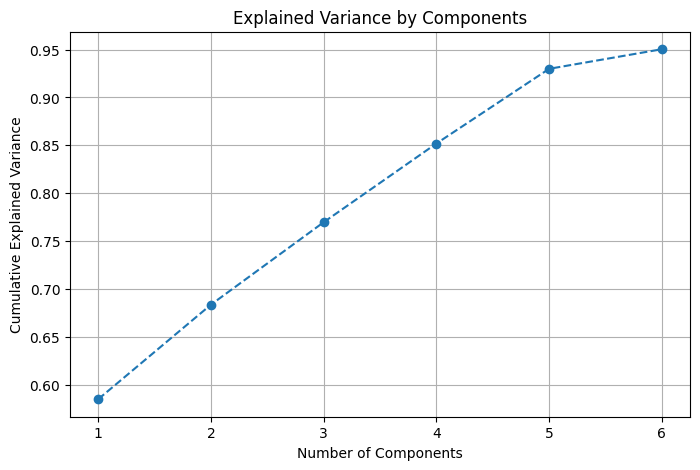

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

### 3.2 KNN <a id='3_2'></a>

- We use PCAed data for KNN

-----------------------------------Fold 1-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.5919136680006245
The brier score is:0.2711761263897016
The calibrated model scoring: 
The roc_auc score is:0.5919136680006245
The brier score is:0.24734308802856395


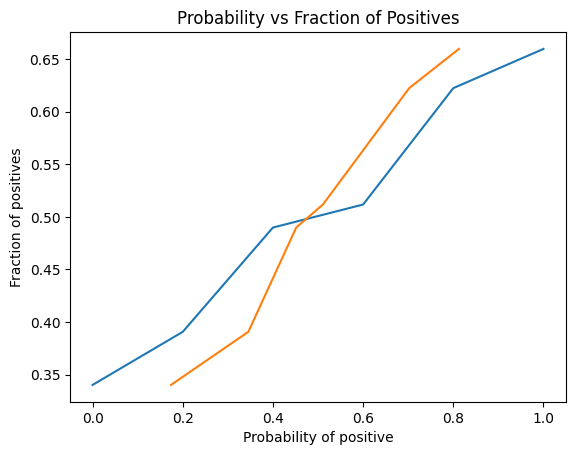

-----------------------------------Fold 2-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.5939653613962813
The brier score is:0.2698186073727326
The calibrated model scoring: 
The roc_auc score is:0.5902942884377294
The brier score is:0.24532204154745105


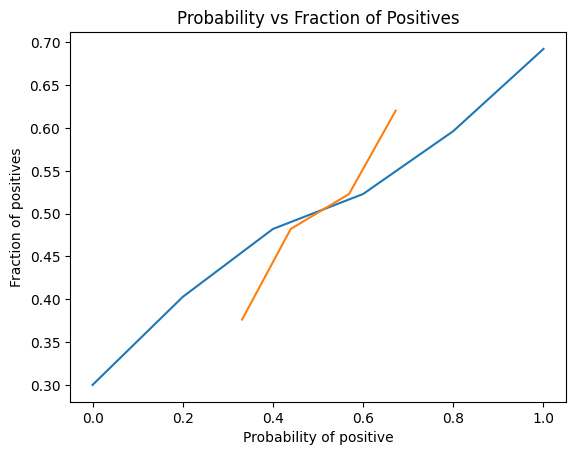

-----------------------------------Fold 3-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.631961734938439
The brier score is:0.25488589818607377
The calibrated model scoring: 
The roc_auc score is:0.631961734938439
The brier score is:0.23829783078237388


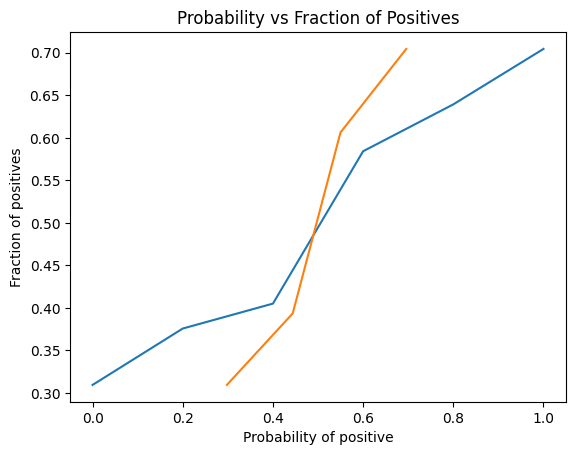

In [14]:
X_pca = X_pca
y = complete_cleaning['target_x']

best_brier_score = float('inf')
best_model = None
fold = 0

knn = KNeighborsClassifier()
test_size = len(y) // 4

tscv = TimeSeriesSplit(n_splits=3, test_size=test_size)
fold = 0
for train_index, test_index in tscv.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # include a validation set for calibration
    split_index = int(len(X_train) * 0.8)  # 80% training, 20% validation
    X_train_split, X_val = X_train[:split_index], X_train[split_index:]
    y_train_split, y_val = y_train.iloc[:split_index], y_train.iloc[split_index:]
    
    fold += 1 
    
    knn.fit(X_train_split, y_train_split)
    y_pred = knn.predict_proba(X_test)[:, 1]
    
    print(f'-----------------------------------Fold {fold}-----------------------------------')
    print('The uncalibrated model scoring: ')
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'The roc_auc score is:{roc_auc}')
    brier = brier_score_loss(y_test, y_pred)
    print(f'The brier score is:{brier}')
    
    frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
    sns.lineplot(x=pred_prob, y=frac_of_positives)
    plt.title("Probability vs Fraction of Positives")
    xlabel = plt.xlabel("Probability of positive")
    ylavel = plt.ylabel("Fraction of positives")
    
    # calibrate the model using the validation sets
    calibrated_knn = CalibratedClassifierCV(knn, cv='prefit', method='isotonic')
    calibrated_knn.fit(X_val, y_val)
    y_pred = calibrated_knn.predict_proba(X_test)[:, 1]
    
    print('The calibrated model scoring: ')
    roc_auc_calibrated = roc_auc_score(y_test, y_pred)
    print(f'The roc_auc score is:{roc_auc_calibrated}')
    brier_calibrated = brier_score_loss(y_test, y_pred)
    print(f'The brier score is:{brier_calibrated}')
    
    frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
    sns.lineplot(x=pred_prob, y=frac_of_positives)
    plt.title("Probability vs Fraction of Positives")
    xlabel = plt.xlabel("Probability of positive")
    ylavel = plt.ylabel("Fraction of positives")
    plt.show()
    
    if(brier_calibrated < best_brier_score):
        best_brier_score = brier_calibrated
        best_model = calibrated_knn

## 4. Hyperparameters Tuning <a id='4'></a>

In [15]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Extended range for regularization strength
    'penalty': ['l2', 'none', 'elasticnet'],  # 'l1' penalty is notably absent as its compatibility is limited
    'solver': ['lbfgs', 'saga'],  # 'liblinear' is limited to 'l1' and 'l2'; 'newton-cg', 'sag', and 'saga' support only 'l2' and none. 'saga' supports 'elasticnet'.
    'l1_ratio': [None, 0.25, 0.5, 0.75],  # Only applicable with 'saga' solver and 'elasticnet' penalty
    'max_iter': [100, 1000, 5000],  # Considering more iterations for convergence
    'class_weight': [None, 'balanced'],  # To handle imbalanced classes
    'fit_intercept': [True, False],  # Whether to include an intercept term
}

# Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Assuming X_pca and y are defined

results_list = []  # Will collect dicts of parameters and scores

# Iterate over all combinations generated by ParameterGrid, using tqdm for progress indication
for params in tqdm(list(ParameterGrid(param_grid)), desc="Hyperparameter Tuning Progress"):
    split_scores = []  # To store the Brier scores for each split

    for train_index, test_index in tscv.split(X_pca):
        X_train, X_test = X_pca[train_index], X_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Initialize and train the KNN model for the current split
        knn = KNeighborsClassifier(**params)
        knn.fit(X_train, y_train)

        # For KNN, calibration is optional and depends on your need for calibrated probabilities
        calibrated_knn = CalibratedClassifierCV(knn, cv='prefit', method='isotonic')
        calibrated_knn.fit(X_train, y_train)

        # Predict probabilities and calculate Brier score
        y_pred_probs = calibrated_knn.predict_proba(X_test)[:, 1]
        split_score = brier_score_loss(y_test, y_pred_probs)
        split_scores.append(split_score)

    # Append results for this parameter set
    results_list.append({
        **params,
        'Average_Brier_score': np.mean(split_scores),
        'First_Brier_scores': split_scores[0],
        'Second_Brier_scores': split_scores[1],
        'Third_Brier_scores': split_scores[2]
    })

# Convert list of results to DataFrame
results_df = pd.DataFrame(results_list)

# Sorting and resetting index for better readability
results_df.sort_values(by='Average_Brier_score', ascending=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)

Hyperparameter Tuning Progress:  75%|██████▊  | 144/192 [01:07<00:19,  2.43it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Hyperparameter Tuning Progress: 100%|█████████| 192/192 [01:20<00:00,  2.38it/s]


NameError: name 'resultsz_df' is not defined

In [16]:
results_df

,algorithm,leaf_size,n_neighbors,p,weights,Average_Brier_score,First_Brier_scores,Second_Brier_scores,Third_Brier_scores
0,ball_tree,40,10,2,distance,0.244627,0.246947,0.250115,0.236821
1,kd_tree,40,10,2,distance,0.244627,0.246947,0.250115,0.236821
2,kd_tree,30,10,2,distance,0.244627,0.246947,0.250115,0.236821
3,kd_tree,20,10,2,distance,0.244627,0.246947,0.250115,0.236821
4,ball_tree,30,10,2,distance,0.244627,0.246947,0.250115,0.236821
...,...,...,...,...,...,...,...,...,...
187,kd_tree,30,3,2,distance,0.298842,0.302060,0.301704,0.292762
188,auto,40,3,2,distance,0.298842,0.302060,0.301704,0.292762
189,brute,40,3,2,distance,0.298842,0.302060,0.301704,0.292762
190,brute,20,3,2,distance,0.298842,0.302060,0.301704,0.292762
